In [107]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchvision.models.vgg import VGG

In [108]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [109]:
from __future__ import print_function
import cv2

In [110]:
cfg = {
    'vgg11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M']
}

In [111]:
def makes_layers(cfg, batch_norm = False):
    layers = []
    in_channels = 3
    for each in cfg:
        if each == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, each, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(each), nn.ReLU(inplace = True)]
            else:
                layers += [conv2d, nn.ReLU(inplace = True)]
            in_channels = each 
    return nn.Sequential(*layers)

In [112]:
ranges = {
    'vgg11': ((0,3), (3,6), (6,11), (11,16), (16, 21)),
    'vgg13': ((0,5), (5,10), (10, 15), (15,20), (20,25)),
    'vgg16': ((0,5), (5,10), (10,17), (17,24), (24,31)),
    'vgg19': ((0,5), (5,10), (10,19), (19,28), (28, 37))
}

- Use of Super Keyword: https://stackoverflow.com/questions/576169/understanding-python-super-with-init-methods
- requires_grad to True to any tensor, then PyTorch will automatically track and calculate gradients for that tensor.

In [113]:
class VGGNet(VGG):
    def __init__(self, pretrain = True, model = 'vgg16', requires_grad = True, remove_fc = True, show_params = False):
        super().__init__(makes_layers(cfg[model]))
        
        self.ranges = ranges[model]
        
        if pretrain:
            exec("self.load_state_dict(models.%s(pretrained=True).state_dict())" % model)

        if not requires_grad:
            for param in super().parameters():
                param.requires_grad = False
        
        if remove_fc:  # delete redundant fully-connected layer params, can save memory
            del self.classifier

        if show_params:
            for name, param in self.named_parameters():
                print(name, param.size())
        
    def forward(self, x):
        output = {}
        
        for idx in range(len(self.ranges)):
            for layers in range(self.ranges[idx][0], self.ranges[idx][1]):
                x =self.features[layers](x)
            output["x%d"%(idx+1)] = x
            
        return output


In [114]:
batch_size, n_class, h, w = 10, 20, 160, 160

In [115]:
vgg_model = VGGNet(requires_grad=True)
input = torch.autograd.Variable(torch.randn(batch_size, 3, 224, 224))
output = vgg_model(input)
assert output['x5'].size() == torch.Size([batch_size, 512, 7, 7])

In [116]:
vgg_model

VGGNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilatio

In [117]:
class FCNs(nn.Module):
    def __init__(self, pretrained_net, n_class):
        super().__init__()
        
        self.n_class = n_class
        self.pretrained_net = pretrained_net
        self.relu = nn.ReLU(inplace = True)
        
        self.deconv1 = nn.ConvTranspose2d(512,512, kernel_size=3, stride=2, padding=1, dilation=1, output_padding = 1)
        self.bn1 = nn.BatchNorm2d(512)
        
        self.deconv2 = nn.ConvTranspose2d(512,256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding = 1)
        self.bn2 = nn.BatchNorm2d(256)   
    
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding = 1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding = 1)
        self.bn4 = nn.BatchNorm2d(64)
        
        self.deconv5 = nn.ConvTranspose2d(64,32, kernel_size=3, stride=2, padding=1, dilation=1, output_padding = 1)
        self.bn5 = nn.BatchNorm2d(32)
        
        self.classifier = nn.Conv2d(32, n_class, kernel_size=1)

    def forward(self, x):
        output = self.pretrained_net(x)
        x5 = output['x5']  # size=(N, 512, x.H/32, x.W/32)
        x4 = output['x4']  # size=(N, 512, x.H/16, x.W/16)
        x3 = output['x3']  # size=(N, 256, x.H/8,  x.W/8)
        x2 = output['x2']  # size=(N, 128, x.H/4,  x.W/4)
        x1 = output['x1']  # size=(N, 64, x.H/2,  x.W/2)
        
        score = self.bn1(self.relu(self.deconv1(x5)))     # size=(N, 512, x.H/16, x.W/16)
        score = score + x4                                # element-wise add, size=(N, 512, x.H/16, x.W/16)
        score = self.bn2(self.relu(self.deconv2(score)))  # size=(N, 256, x.H/8, x.W/8)
        score = score + x3                                # element-wise add, size=(N, 256, x.H/8, x.W/8)
        score = self.bn3(self.relu(self.deconv3(score)))  # size=(N, 128, x.H/4, x.W/4)
        score = score + x2                                # element-wise add, size=(N, 128, x.H/4, x.W/4)
        score = self.bn4(self.relu(self.deconv4(score)))  # size=(N, 64, x.H/2, x.W/2)
        score = score + x1                                # element-wise add, size=(N, 64, x.H/2, x.W/2)
        score = self.bn5(self.relu(self.deconv5(score)))  # size=(N, 32, x.H, x.W)
        score = self.classifier(score)                    # size=(N, n_class, x.H/1, x.W/1)
        return score


In [118]:
fcn_model = FCNs(pretrained_net=vgg_model, n_class=n_class)
input = torch.autograd.Variable(torch.randn(batch_size, 3, h, w))
output = fcn_model(input)
assert output.size() == torch.Size([batch_size, n_class, h, w])

In [119]:
# test a random batch, loss should decrease
fcn_model = FCNs(pretrained_net=vgg_model, n_class=n_class)
criterion = nn.BCELoss()
optimizer = optim.SGD(fcn_model.parameters(), lr=1e-3, momentum=0.9)
input = torch.autograd.Variable(torch.randn(batch_size, 3, h, w))
y = torch.autograd.Variable(torch.randn(batch_size, n_class, h, w), requires_grad=False)
for iter in range(10):
    optimizer.zero_grad()
    output = fcn_model(input)
    output = nn.functional.sigmoid(output)
    loss = criterion(output, y)
    loss.backward()
    print("iter{}, loss {}".format(iter, loss))
    optimizer.step()

C:\Users\arava\anaconda3\envs\dl\lib\site-packages\torch\nn\functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


iter0, loss 0.7405931353569031
iter1, loss 0.7405620217323303
iter2, loss 0.7405028939247131
iter3, loss 0.7404186129570007
iter4, loss 0.7403117418289185
iter5, loss 0.7401845455169678
iter6, loss 0.740039050579071
iter7, loss 0.7398772239685059
iter8, loss 0.739700973033905
iter9, loss 0.7395115494728088


- Torch VGG Class: https://github.com/pytorch/vision/blob/main/torchvision/models/vgg.py

- Dataset: https://www.kaggle.com/jcoral02/camvid

In [120]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import scipy.misc
import random
import os

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import utils

In [121]:
root_dir   = "D:/Datasets/CV/Image_Segmentation/CamVid/"
train_file = os.path.join(root_dir, "train.csv")
val_file   = os.path.join(root_dir, "val.csv")

In [122]:
from pathlib import Path

In [123]:
import os
print(os.listdir("D:/Datasets/CV/Image_Segmentation/CamVid/"))

['class_dict.csv', 'Labeled_idx', 'test', 'test_labels', 'train', 'train_idx', 'train_labels', 'val', 'val_labels']


In [124]:
dataset_path = Path("D:/Datasets/CV/Image_Segmentation/CamVid/")
list(dataset_path.iterdir())

[WindowsPath('D:/Datasets/CV/Image_Segmentation/CamVid/class_dict.csv'),
 WindowsPath('D:/Datasets/CV/Image_Segmentation/CamVid/Labeled_idx'),
 WindowsPath('D:/Datasets/CV/Image_Segmentation/CamVid/test'),
 WindowsPath('D:/Datasets/CV/Image_Segmentation/CamVid/test_labels'),
 WindowsPath('D:/Datasets/CV/Image_Segmentation/CamVid/train'),
 WindowsPath('D:/Datasets/CV/Image_Segmentation/CamVid/train_idx'),
 WindowsPath('D:/Datasets/CV/Image_Segmentation/CamVid/train_labels'),
 WindowsPath('D:/Datasets/CV/Image_Segmentation/CamVid/val'),
 WindowsPath('D:/Datasets/CV/Image_Segmentation/CamVid/val_labels')]

In [125]:
train_imgs = list((dataset_path / "train").glob("*.png"))
train_labels = list((dataset_path / "train_labels").glob("*.png"))
val_imgs = list((dataset_path / "val").glob("*.png"))
val_labels = list((dataset_path / "val_labels").glob("*.png"))
test_imgs = list((dataset_path / "test").glob("*.png"))
test_labels = list((dataset_path / "test_labels").glob("*.png"))

In [126]:
# assert len(train_imgs) == len(train_labels), "No of Train images and label mismatch"
# assert len(val_imgs) == len(val_labels), "No of Train images and label mismatch"
# assert len(test_imgs) == len(test_labels), "No of Test images and label mismatch"

In [127]:
sorted(train_imgs), sorted(train_labels), sorted(val_imgs), sorted(val_labels), sorted(test_imgs), sorted(test_labels);

In [128]:
for im in train_imgs:
    assert dataset_path / "train_labels" / (im.stem +"_L.png") in train_labels , "{im} not there in label folder"
for im in val_imgs:
    assert dataset_path / "val_labels" / (im.stem +"_L.png") in val_labels , "{im} not there in label folder"
for im in test_imgs:
    assert dataset_path / "test_labels" / (im.stem +"_L.png") in test_labels , "{im} not there in label folder"

In [129]:
def make_pair(img,label,dataset):
    pairs = []
    for im in img:
        pairs.append((im , dataset / label / (im.stem +"_L.png")))
    
    return pairs

In [130]:
train_pair = make_pair(train_imgs, "train_labels", dataset_path)
val_pair = make_pair(val_imgs, "val_labels", dataset_path)
test_pair = make_pair(test_imgs, "test_labels", dataset_path)

In [131]:
train_pair[0]

(WindowsPath('D:/Datasets/CV/Image_Segmentation/CamVid/train/0001TP_006690.png'),
 WindowsPath('D:/Datasets/CV/Image_Segmentation/CamVid/train_labels/0001TP_006690_L.png'))

In [132]:
import pandas as pd
classes = pd.read_csv(dataset_path / 'class_dict.csv', index_col =0)

In [133]:
classes = classes[['r', 'g', 'b']]
classes

,r,g,b
name,,,
Animal,64,128,64
Archway,192,0,128
Bicyclist,0,128,192
Bridge,0,128,64
Building,128,0,0
Car,64,0,128
CartLuggagePram,64,0,192
Child,192,128,64
Column_Pole,192,192,128


In [134]:
n_classes = len(classes)
n_classes

32

In [135]:
cls2rgb = {cl:list(classes.loc[cl, :]) for cl in classes.index}
cls2rgb

{'Animal': [64, 128, 64],
 'Archway': [192, 0, 128],
 'Bicyclist': [0, 128, 192],
 'Bridge': [0, 128, 64],
 'Building': [128, 0, 0],
 'Car': [64, 0, 128],
 'CartLuggagePram': [64, 0, 192],
 'Child': [192, 128, 64],
 'Column_Pole': [192, 192, 128],
 'Fence': [64, 64, 128],
 'LaneMkgsDriv': [128, 0, 192],
 'LaneMkgsNonDriv': [192, 0, 64],
 'Misc_Text': [128, 128, 64],
 'MotorcycleScooter': [192, 0, 192],
 'OtherMoving': [128, 64, 64],
 'ParkingBlock': [64, 192, 128],
 'Pedestrian': [64, 64, 0],
 'Road': [128, 64, 128],
 'RoadShoulder': [128, 128, 192],
 'Sidewalk': [0, 0, 192],
 'SignSymbol': [192, 128, 128],
 'Sky': [128, 128, 128],
 'SUVPickupTruck': [64, 128, 192],
 'TrafficCone': [0, 0, 64],
 'TrafficLight': [0, 64, 64],
 'Train': [192, 64, 128],
 'Tree': [128, 128, 0],
 'Truck_Bus': [192, 128, 192],
 'Tunnel': [64, 0, 64],
 'VegetationMisc': [192, 192, 0],
 'Void': [0, 0, 0],
 'Wall': [64, 192, 0]}

In [136]:
import cv2
%matplotlib inline
import cv2
import matplotlib.pyplot as plt

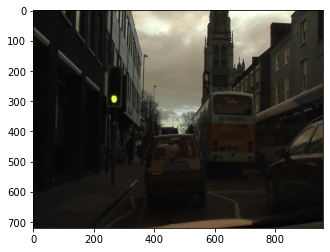

In [137]:
img = cv2.imread('D:/Datasets/CV/Image_Segmentation/CamVid'+'/train/0001TP_006690.png')
plt.imshow(img)

In [138]:
import numpy as np
mask = cv2.imread('D:/Datasets/CV/Image_Segmentation/CamVid' + '/train_labels/0001TP_006690_L.png')
mask = cv2.cvtColor((mask).astype(np.uint8), cv2.COLOR_BGR2RGB)# If you want to get the same order as in the color mapping of CAMVID, use the cv converted

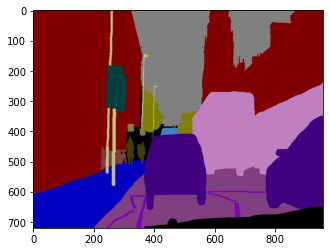

In [139]:
plt.imshow(mask)

In [33]:
mask = np.array(mask)

In [34]:
mask.shape

(720, 960, 3)

In [35]:
mask

array([[[128,   0,   0],
        [128,   0,   0],
        [128,   0,   0],
        ...,
        [128,   0,   0],
        [128,   0,   0],
        [128,   0,   0]],

       [[128,   0,   0],
        [128,   0,   0],
        [128,   0,   0],
        ...,
        [128,   0,   0],
        [128,   0,   0],
        [128,   0,   0]],

       [[128,   0,   0],
        [128,   0,   0],
        [128,   0,   0],
        ...,
        [128,   0,   0],
        [128,   0,   0],
        [128,   0,   0]],

       ...,

       [[  0,   0, 192],
        [  0,   0, 192],
        [  0,   0, 192],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0, 192],
        [  0,   0, 192],
        [  0,   0, 192],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0, 192],
        [  0,   0, 192],
        [  0,   0, 192],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]]

In [36]:
def adjust_mask(mask, flat=False):
    semantic_map = []
    for colour in list(cls2rgb.values()):        
        equality = np.equal(mask, colour)# 256x256x3 with True or False
        class_map = np.all(equality, axis = -1)# 256x256 If all True, then True, else False
        semantic_map.append(class_map)# List of 256x256 arrays, map of True for a given found color at the pixel, and False otherwise.
    semantic_map = np.stack(semantic_map, axis=-1)# 256x256x32 True only at the found color, and all False otherwise.
    if flat:
        semantic_map = np.reshape(semantic_map, (-1,256*256))
    return np.float32(semantic_map)# convert to numbers

In [37]:
new_mask = adjust_mask(mask)

In [38]:
new_mask.shape

(720, 960, 32)

In [39]:
idx2rgb={idx:np.array(rgb) for idx, (cl, rgb) in enumerate(cls2rgb.items())}

In [40]:
# Map the idx back to rgb
def map_class_to_rgb(p):
  
  return idx2rgb[p[0]]

rgb_mask = np.apply_along_axis(map_class_to_rgb, -1, np.expand_dims(np.argmax(new_mask, axis=-1), -1))

In [41]:
np.transpose(np.expand_dims(np.argmax(new_mask, axis=-1), -1), (2, 0, 1))

array([[[ 4,  4,  4, ...,  4,  4,  4],
        [ 4,  4,  4, ...,  4,  4,  4],
        [ 4,  4,  4, ...,  4,  4,  4],
        ...,
        [19, 19, 19, ..., 30, 30, 30],
        [19, 19, 19, ..., 30, 30, 30],
        [19, 19, 19, ..., 30, 30, 30]]], dtype=int64)

In [42]:
#plt.imshow(rgb_mask)

- https://www.kaggle.com/code/mukulkr/camvid-segmentation-using-unet/notebook
- https://www.kaggle.com/code/mukulkr/camvid-segmentation-using-unet/notebook

In [43]:
from __future__ import print_function

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import scipy.misc
import random
import os

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import utils

In [44]:
root_dir   = "D:/Datasets/CV/Image_Segmentation/CamVid/"
train_file = os.path.join(root_dir, "train")
val_file   = os.path.join(root_dir, "val")
test_file   = os.path.join(root_dir, "test")

In [45]:
num_class = 32

In [46]:
means     = np.array([103.939, 116.779, 123.68]) / 255.
h, w      = 720, 960
train_h   = int(h * 2 / 3)  # 480
train_w   = int(w * 2 / 3)  # 640
val_h     = int(h/32) * 32  # 704
val_w     = w               # 960

In [47]:
class CamVidDataset(Dataset):

    def __init__(self, data_pair, phase, n_class=num_class, crop=True, flip_rate=0.5):
        self.data      = data_pair
        self.means     = means
        self.n_class   = n_class

        self.flip_rate = flip_rate
        self.crop      = crop
        if phase == 'train':
            self.new_h = train_h
            self.new_w = train_w
        elif phase == 'val':
            self.flip_rate = 0.
            #self.crop = False
            self.new_h = val_h
            self.new_w = val_w


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, seg_map   = self.data[idx][0], self.data[idx][1]
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        mask = cv2.imread(str(seg_map))
        mask = cv2.cvtColor((mask).astype(np.uint8), cv2.COLOR_BGR2RGB)
        
        label = adjust_mask(mask)

        if self.crop:
            h, w, _ = img.shape
            top   = random.randint(0, h - self.new_h)
            left  = random.randint(0, w - self.new_w)
            img   = img[top:top + self.new_h, left:left + self.new_w]
            label = label[top:top + self.new_h, left:left + self.new_w]

        if random.random() < self.flip_rate:
            img   = np.fliplr(img)
            label = np.fliplr(label)

        # reduce mean
        img = img[:, :, ::-1]  # switch to BGR
        img = np.transpose(img, (2, 0, 1)) / 255.
        img[0] -= self.means[0]
        img[1] -= self.means[1]
        img[2] -= self.means[2]

        # convert to tensor
        img = torch.from_numpy(img.copy()).float()
        label = torch.from_numpy(label.copy()).long()


        sample = {'X': img, 'Y': mask, 'l': label}

        return sample

In [48]:
train_dataset = CamVidDataset(train_pair, 'train', num_class)

In [49]:
sample = train_dataset.__getitem__(1)

In [50]:
sample['l']

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        ...,

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 1, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0,

In [51]:
rgb_mask = np.apply_along_axis(map_class_to_rgb, -1, np.expand_dims(np.argmax(sample['l'], axis=-1), -1))
#plt.imshow(rgb_mask)

In [52]:
# def show_batch(batch):
#     img_batch = batch['X']
#     img_batch[:,0,...].add_(means[0])
#     img_batch[:,1,...].add_(means[1])
#     img_batch[:,2,...].add_(means[2])
#     batch_size = len(img_batch)

#     grid = utils.make_grid(img_batch)
#     plt.imshow(grid.numpy()[::-1].transpose((1, 2, 0)))

#     plt.title('Batch from dataloader')

In [53]:
# batch_size = 4
# dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# for i, batch in enumerate(dataloader):
#     print(i, batch['X'].size(), batch['Y'].size())

#     # observe 4th batch
#     if i == 3:
#         plt.figure()
#         show_batch(batch)
#         plt.axis('off')
#         plt.ioff()
#         plt.show()
#         break

In [54]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import DataLoader


from matplotlib import pyplot as plt
import numpy as np
import time
import sys
import os

In [55]:
n_class    = 32

batch_size = 2
epochs     = 30
lr         = 1e-4
momentum   = 0
w_decay    = 1e-5
step_size  = 20
gamma      = 0.5

In [56]:
configs    = "FCNs-BCEWithLogits_batch{}_epoch{}_RMSprop_scheduler-step{}-gamma{}_lr{}_momentum{}_w_decay{}".format(batch_size, epochs, step_size, gamma, lr, momentum, w_decay)
print("Configs:", configs)


Configs: FCNs-BCEWithLogits_batch2_epoch30_RMSprop_scheduler-step20-gamma0.5_lr0.0001_momentum0_w_decay1e-05


In [57]:
model_dir = "models"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
model_path = os.path.join(model_dir, configs)

In [58]:
use_gpu = torch.cuda.is_available()
num_gpu = list(range(torch.cuda.device_count()))

In [59]:
num_gpu

[0]

In [60]:
use_gpu

True

In [61]:
train_dataset = CamVidDataset(train_pair, 'train', num_class)
dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [62]:
val_data = CamVidDataset(val_pair, 'val', num_class)
val_loader = DataLoader(val_data, batch_size=1)

In [63]:
vgg_model = VGGNet(requires_grad=True, remove_fc=True)
fcn_model = FCNs(pretrained_net=vgg_model, n_class=n_class)

In [64]:
if use_gpu:
    ts = time.time()
    vgg_model = vgg_model.cuda()
    fcn_model = fcn_model.cuda()
    fcn_model = nn.DataParallel(fcn_model, device_ids=num_gpu)
    print("Finish cuda loading, time elapsed {}".format(time.time() - ts))

Finish cuda loading, time elapsed 1.121345043182373


In [65]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.RMSprop(fcn_model.parameters(), lr=lr, momentum=momentum, weight_decay=w_decay)
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)  # decay LR by a factor of 0.5 every 30 epochs


In [66]:
# create dir for score
score_dir = os.path.join("scores", configs)
if not os.path.exists(score_dir):
    os.makedirs(score_dir)
IU_scores    = np.zeros((epochs, n_class))
pixel_scores = np.zeros(epochs)

In [67]:
use_gpu

True

In [68]:
def train():
    for epoch in range(epochs):
        scheduler.step()

        ts = time.time()
        for iter, batch in enumerate(dataloader):
            optimizer.zero_grad()

            if use_gpu:
                inputs = Variable(batch['X'].cuda())
                labels = Variable(batch['l'].cuda())
            else:
                inputs, labels = Variable(batch['X']), Variable(batch['l'])

            outputs = fcn_model(inputs)
            loss = criterion(outputs, labels.permute(0, 3, 1, 2).cuda().float())
            loss.backward()
            optimizer.step()

            if iter % 10 == 0:
                print("epoch{}, iter{}, loss: {}".format(epoch, iter, loss.item())) #data[0]
        
        print("Finish epoch {}, time elapsed {}".format(epoch, time.time() - ts))
        torch.save(fcn_model, model_path)

        val(epoch)

In [69]:
np.transpose(np.expand_dims(np.argmax(new_mask, axis=-1), -1), (2, 0, 1))

array([[[ 4,  4,  4, ...,  4,  4,  4],
        [ 4,  4,  4, ...,  4,  4,  4],
        [ 4,  4,  4, ...,  4,  4,  4],
        ...,
        [19, 19, 19, ..., 30, 30, 30],
        [19, 19, 19, ..., 30, 30, 30],
        [19, 19, 19, ..., 30, 30, 30]]], dtype=int64)

In [70]:
def val(epoch):
    fcn_model.eval()
    total_ious = []
    pixel_accs = []
    for iter, batch in enumerate(val_loader):
        if use_gpu:
            inputs = Variable(batch['X'].cuda())
        else:
            inputs = Variable(batch['X'])

        output = fcn_model(inputs)
        output = output.data.cpu().numpy()
        #print('Out '+str(output.shape))

        N, c, h, w = output.shape
        pred = output.transpose(0, 2, 3, 1).reshape(-1, n_class).argmax(axis=1).reshape(N, h, w)
        #print('pred : '+str(pred))

        #target = batch['l'].cpu().numpy().reshape(N, h, w)
        #print(np.transpose(np.expand_dims(np.argmax(batch['l'].cpu().numpy(), axis = -1), -1), (0,3,1,2))[0])
        target = np.transpose(np.expand_dims(np.argmax(batch['l'].cpu().numpy(), axis = -1), -1), (0,3,1,2))[0]
        #print('target : '+str(target.shape))
        
        for p, t in zip(pred, target):
            total_ious.append(iou(p, t))
            pixel_accs.append(pixel_acc(p, t))
    # Calculate average IoU
    total_ious = np.array(total_ious).T  # n_class * val_len
    ious = np.nanmean(total_ious, axis=1)
    pixel_accs = np.array(pixel_accs).mean()
    print("epoch{}, pix_acc: {}, meanIoU: {}, IoUs: {}".format(epoch, pixel_accs, np.nanmean(ious), ious))
    IU_scores[epoch] = ious
    np.save(os.path.join(score_dir, "meanIU"), IU_scores)
    pixel_scores[epoch] = pixel_accs
    np.save(os.path.join(score_dir, "meanPixel"), pixel_scores)


In [71]:
def iou(pred, target):
    ious = []
    for cls in range(n_class):
        pred_inds = pred == cls
        target_inds = target == cls
        intersection = pred_inds[target_inds].sum()
        union = pred_inds.sum() + target_inds.sum() - intersection
        if union == 0:
            ious.append(float('nan'))  # if there is no ground truth, do not include in evaluation
        else:
            ious.append(float(intersection) / max(union, 1))
        # print("cls", cls, pred_inds.sum(), target_inds.sum(), intersection, float(intersection) / max(union, 1))
    return ious

In [72]:
def pixel_acc(pred, target):
    correct = (pred == target).sum()
    total   = (target == target).sum()
    return correct / total

In [73]:
train()

C:\Users\arava\anaconda3\envs\dl\lib\site-packages\torch\optim\lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


epoch0, iter0, loss: 0.7315198183059692
epoch0, iter10, loss: 0.698768138885498
epoch0, iter20, loss: 0.6918806433677673
epoch0, iter30, loss: 0.6907685399055481
epoch0, iter40, loss: 0.6793663501739502
epoch0, iter50, loss: 0.6724218130111694
epoch0, iter60, loss: 0.674956202507019
epoch0, iter70, loss: 0.6671395301818848
epoch0, iter80, loss: 0.6689653396606445
epoch0, iter90, loss: 0.6684396862983704
epoch0, iter100, loss: 0.66270512342453
epoch0, iter110, loss: 0.6582450270652771
epoch0, iter120, loss: 0.6617234349250793
epoch0, iter130, loss: 0.656397819519043
epoch0, iter140, loss: 0.6544735431671143
epoch0, iter150, loss: 0.6499125957489014
epoch0, iter160, loss: 0.6606897711753845
epoch0, iter170, loss: 0.6453736424446106
epoch0, iter180, loss: 0.6452251672744751
Finish epoch 0, time elapsed 224.15115070343018
epoch0, pix_acc: 0.4530831305786829, meanIoU: 0.05703590716363961, IoUs: [0.00000000e+00 1.83358176e-04 1.48865882e-06 0.00000000e+00
 3.52235017e-01 1.12568405e-02 8.796

C:\Users\arava\AppData\Local\Temp\ipykernel_13972\1768166139.py:29: RuntimeWarning: Mean of empty slice
  ious = np.nanmean(total_ious, axis=1)


epoch1, pix_acc: 0.5475189071641541, meanIoU: 0.0749307257695287, IoUs: [           nan 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.45371996e-01 2.00457436e-04 0.00000000e+00 0.00000000e+00
 2.93171894e-06 0.00000000e+00 4.97257317e-04 0.00000000e+00
 0.00000000e+00            nan 0.00000000e+00            nan
 8.46154973e-05 6.84125691e-01            nan 1.33345280e-04
 0.00000000e+00 5.91283406e-01 0.00000000e+00            nan
 0.00000000e+00            nan 2.50158946e-01 0.00000000e+00
            nan 0.00000000e+00 1.40949733e-03 0.00000000e+00]
epoch2, iter0, loss: 0.08591822534799576
epoch2, iter10, loss: 0.06089702248573303
epoch2, iter20, loss: 0.05453679710626602
epoch2, iter30, loss: 0.07214964926242828
epoch2, iter40, loss: 0.050020020455121994
epoch2, iter50, loss: 0.07530437409877777
epoch2, iter60, loss: 0.06281208246946335
epoch2, iter70, loss: 0.052440185099840164
epoch2, iter80, loss: 0.13064193725585938
epoch2, iter90, loss: 0.06015339493751526
epoch2, iter100, l

In [86]:
torch.save(fcn_model.state_dict(), r"C:/Users/arava/Masters/CV/Image_Segmentation/FCN_Model.pth")

In [74]:
torch.save(fcn_model, r"C:/Users/arava/Masters/CV/Image_Segmentation/FCN_Complete.pth")

In [75]:
import os
print(os.getcwd())

C:\Users\arava\Masters\CV\Image_Segmentation


In [87]:
#torch.cuda.empty_cache()

In [142]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import scipy.misc
import random
import os

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import utils

In [143]:
from pathlib import Path
import cv2
from torch.autograd import Variable

In [144]:
dataset_path = Path("D:/Datasets/CV/Image_Segmentation/CamVid/")

In [145]:
test_imgs = list((dataset_path / "test").glob("*.png"))
test_labels = list((dataset_path / "test_labels").glob("*.png"))

In [146]:
def make_pair(img,label,dataset):
    pairs = []
    for im in img:
        pairs.append((im , dataset / label / (im.stem +"_L.png")))
    return pairs


In [147]:
cls2rgb = {cl:list(classes.loc[cl, :]) for cl in classes.index}

In [148]:
test_pair = make_pair(test_imgs, "test_labels", dataset_path)

In [149]:
means     = np.array([103.939, 116.779, 123.68]) / 255.
h, w      = 720, 960
train_h   = int(h * 2 / 3)  # 480
train_w   = int(w * 2 / 3)  # 640
val_h     = int(h/32) * 32  # 704
val_w     = w               # 960

In [150]:
num_class = 32
class CamVidDataset(Dataset):

    def __init__(self, data_pair, phase, n_class=num_class, crop=True, flip_rate=0.5):
        self.data      = data_pair
        self.means     = means
        self.n_class   = n_class

        self.flip_rate = flip_rate
        self.crop      = crop
        if phase == 'train':
            self.new_h = train_h
            self.new_w = train_w
        elif phase == 'val':
            self.flip_rate = 0.
            #self.crop = False
            self.new_h = val_h
            self.new_w = val_w


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, seg_map   = self.data[idx][0], self.data[idx][1]
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        mask = cv2.imread(str(seg_map))
        mask = cv2.cvtColor((mask).astype(np.uint8), cv2.COLOR_BGR2RGB)
        
        label = adjust_mask(mask)

        if self.crop:
            h, w, _ = img.shape
            top   = random.randint(0, h - self.new_h)
            left  = random.randint(0, w - self.new_w)
            img   = img[top:top + self.new_h, left:left + self.new_w]
            label = label[top:top + self.new_h, left:left + self.new_w]

        if random.random() < self.flip_rate:
            img   = np.fliplr(img)
            label = np.fliplr(label)

        # reduce mean
        img = img[:, :, ::-1]  # switch to BGR
        img = np.transpose(img, (2, 0, 1)) / 255.
        img[0] -= self.means[0]
        img[1] -= self.means[1]
        img[2] -= self.means[2]

        # convert to tensor
        img = torch.from_numpy(img.copy()).float()
        label = torch.from_numpy(label.copy()).long()


        sample = {'X': img, 'Y': mask, 'l': label}

        return sample

In [151]:
test_dataset = CamVidDataset(test_pair, 'val', num_class)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [152]:
def adjust_mask(mask, flat=False):
    semantic_map = []
    for colour in list(cls2rgb.values()):        
        equality = np.equal(mask, colour)# 256x256x3 with True or False
        class_map = np.all(equality, axis = -1)# 256x256 If all True, then True, else False
        semantic_map.append(class_map)# List of 256x256 arrays, map of True for a given found color at the pixel, and False otherwise.
    semantic_map = np.stack(semantic_map, axis=-1)# 256x256x32 True only at the found color, and all False otherwise.
    if flat:
        semantic_map = np.reshape(semantic_map, (-1,256*256))
    return np.float32(semantic_map)# convert to numbers

In [153]:
#model = torch.load('C:/Users/arava/Masters/CV/Image_Segmentation/FCN_Model.pth')

#model = fcn_model()
#fcn_model = nn.DataParallel(fcn_model)
# import time
# use_gpu = torch.cuda.is_available()
# num_gpu = list(range(torch.cuda.device_count()))
# if use_gpu:
#     ts = time.time()
#     vgg_model = vgg_model.cuda()
#     fcn_model = fcn_model.cuda()
#     fcn_model = nn.DataParallel(fcn_model, device_ids=num_gpu)
#     fcn_model.load_state_dict(torch.load('C:/Users/arava/Masters/CV/Image_Segmentation/FCN_Model.pth'), strict=False)
#     print("Finish cuda loading, time elapsed {}".format(time.time() - ts))

In [154]:
idx2rgb={idx:np.array(rgb) for idx, (cl, rgb) in enumerate(cls2rgb.items())}

In [156]:
for iter, batch in enumerate(test_loader):
    if use_gpu:
        inputs = Variable(batch['X'].cuda())
    else:
        inputs = Variable(batch['X'])

    output = fcn_model(inputs)
    output = output.data.cpu().numpy()

    N, c, h, w = output.shape
    pred = output.transpose(0, 2, 3, 1).reshape(-1, n_class).argmax(axis=1).reshape(N, h, w)

    target = np.transpose(np.expand_dims(np.argmax(batch['l'].cpu().numpy(), axis = -1), -1), (0,3,1,2))[0]
    #print(pred[0].shape)
    #print(target[0].shape)

    pred = pred[0]
    image = np.zeros( (pred.shape[0],pred.shape[1],3) ) 
    for i in range(pred.shape[0]) :
        for j in range(pred.shape[1]) :
            color_index = pred[i][j] 
            image[i,j] = idx2rgb[ color_index ]
    original = np.transpose(inputs.cpu().numpy()[0], (1,2,0))*255.
            
    original[0] -= means[0]
    original[1] -= means[1]
    original[2] -= means[2]
    #print(original.shape)
    #print(type(original))
    #plt.imshow(original)
    #plt.imshow(image)
    
    print(target)
    print('pred')
    print(pred)
    
    # Clolor array RGB
#     print(batch['Y'].cpu().numpy()[0])
#     print('pred')
#     print(image)
    
    
    original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
    cv2.imshow('Original',original)
    cv2.imshow('target',batch['Y'].cpu().numpy()[0])
    cv2.imshow('Map',image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
    
    break